Results for CatBoost model with dataset without main columns (StandardScaler normalization):
CatBoost - MSE: 115020.16988292077, R2: 0.8380678159856645


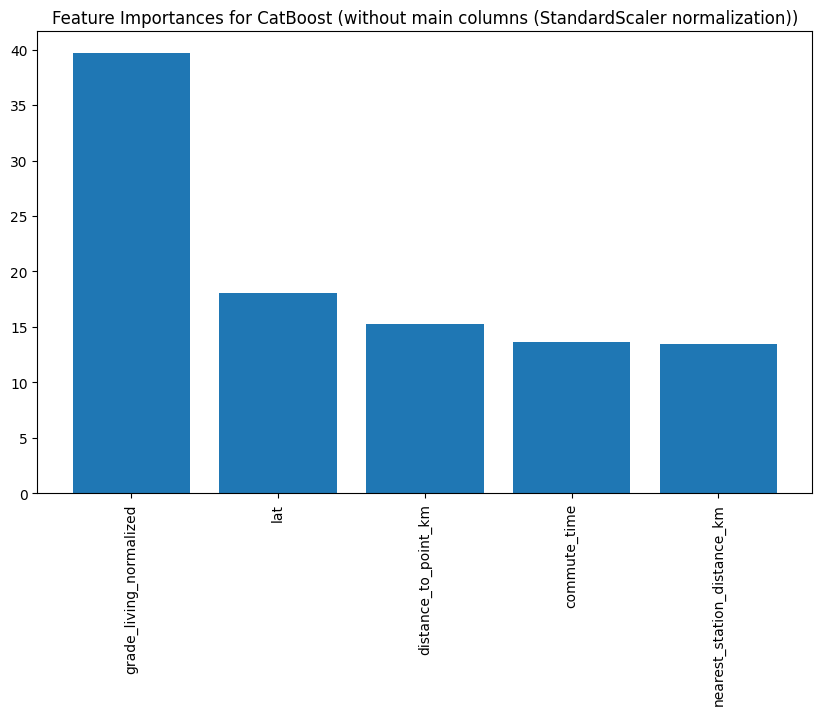

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

important_features = ['grade_living_normalized', 'distance_to_point_km', 'nearest_station_distance_km', 'commute_time', 'lat','cluster_all_data','price']  # Önemli özellikler

# Veriyi yükleme ve işleme (Önceki adımlar)
df = pd.read_csv('clustered_data_v2.csv')

df_wo_main = df[important_features]

# IQR Yöntemi ile Aykırı Değerleri Bulma ve Baskılamak
def cap_outliers(df):
    capped_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        capped_df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        capped_df[col] = np.where(df[col] > upper_bound, upper_bound, capped_df[col])
    return capped_df

df_wo_main_capped = cap_outliers(df_wo_main)

# Eksik veya geçersiz değerleri temizleme
#df_wo_main_capped = df_wo_main_capped.fillna(df_wo_main_capped.mean())

# Feature importance ve model performansını hesaplama fonksiyonu
def evaluate_catboost_model_with_scaler(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # StandardScaler ile normalizasyon
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    feature_importances = model.feature_importances_

    return {"MSE": mse, "R2": r2}, feature_importances, X.columns

# Değerlendirme ve feature importance hesaplama
y_wo_main_capped = df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2]['price']
X_wo_main_capped = df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2].drop(columns=['cluster_all_data','price'], axis=1)

results_wo_main, feature_importances_wo_main, feature_names_wo_main = evaluate_catboost_model_with_scaler(X_wo_main_capped, y_wo_main_capped)

# Performans sonuçlarını yazdırma
print("Results for CatBoost model with dataset without main columns (StandardScaler normalization):")
print(f"CatBoost - MSE: {results_wo_main['MSE']}, R2: {results_wo_main['R2']}")

# Feature importances grafiği
def plot_feature_importances(feature_importances, feature_names, model_name, dataset_name):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
    plt.title(f"Feature Importances for {model_name} ({dataset_name})")
    plt.show()

# Grafiklerle karşılaştırma
plot_feature_importances(feature_importances_wo_main, feature_names_wo_main, "CatBoost", "without main columns (StandardScaler normalization)")


Results for CatBoost model with dataset without main columns:
CatBoost - MSE: 108300.95765177261, R2: 0.8564346091239795


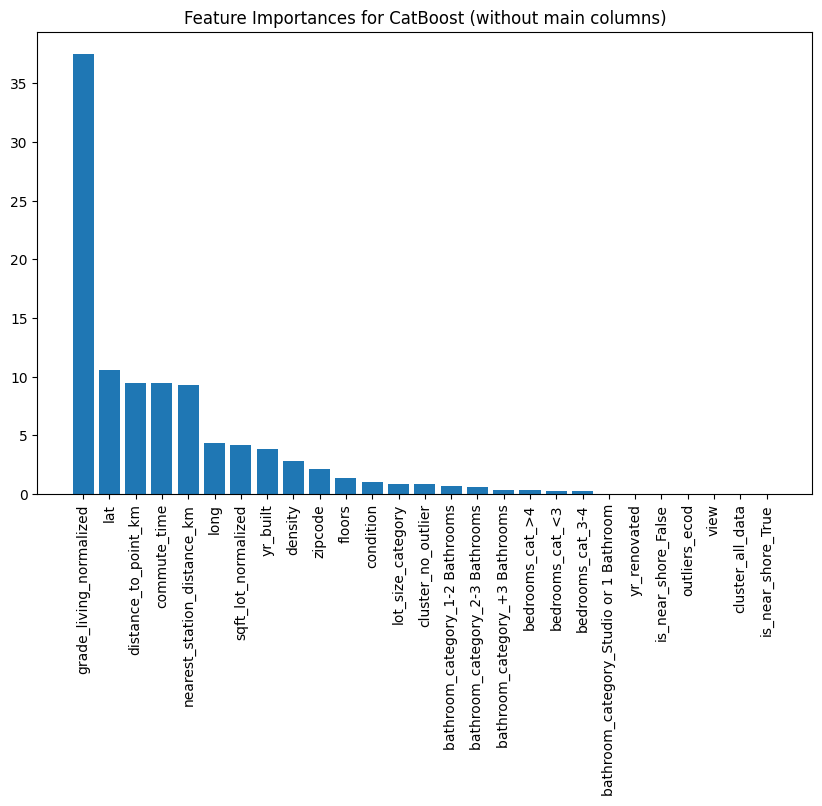

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Veriyi yükleme ve işleme (Önceki adımlar)
df = pd.read_csv('clustered_data_v2.csv')
categorical_columns = ['bathroom_category', 'bedrooms_cat', 'is_near_shore']
df = pd.get_dummies(df, columns=categorical_columns)

columns_to_drop_cat = [
    'lot_size_category', 'grade_living_category', 
    'bathroom_category_+3 Bathrooms', 'bathroom_category_1-2 Bathrooms',
    'bathroom_category_2-3 Bathrooms', 'bathroom_category_Studio or 1 Bathroom', 
    'bedrooms_cat_3-4', 'bedrooms_cat_<3', 'bedrooms_cat_>4','sqft_lot','grade_living','cluster_no_outlier','waterfront'
]

columns_to_drop_main = [
    'bedrooms', 'bathrooms','sqft_lot','grade_living','grade_living_category','waterfront'
]

df_wo_main = df.drop(columns=columns_to_drop_main)

# IQR Yöntemi ile Aykırı Değerleri Bulma ve Baskılamak
def cap_outliers(df):
    capped_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        capped_df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        capped_df[col] = np.where(df[col] > upper_bound, upper_bound, capped_df[col])
    return capped_df

df_wo_main_capped = cap_outliers(df_wo_main)

# Feature importance ve model performansını hesaplama fonksiyonu
def evaluate_catboost_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    feature_importances = model.feature_importances_

    return {"MSE": mse, "R2": r2}, feature_importances, X.columns

# Değerlendirme ve feature importance hesaplama
y_wo_main_capped =  df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2]['price']
X_wo_main_capped = df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2].drop('price', axis=1)

results_wo_main, feature_importances_wo_main, feature_names_wo_main = evaluate_catboost_model(X_wo_main_capped, y_wo_main_capped)

# Performans sonuçlarını yazdırma
print("Results for CatBoost model with dataset without main columns:")
print(f"CatBoost - MSE: {results_wo_main['MSE']}, R2: {results_wo_main['R2']}")

# Feature importances grafiği
def plot_feature_importances(feature_importances, feature_names, model_name, dataset_name):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
    plt.title(f"Feature Importances for {model_name} ({dataset_name})")
    plt.show()

# Grafiklerle karşılaştırma
plot_feature_importances(feature_importances_wo_main, feature_names_wo_main, "CatBoost", "without main columns")
